<a href="https://colab.research.google.com/github/SamKa1u/GenAI-3d-GAN/blob/main/GenAI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Adapted from simple-pytorch-3dgan by xchhuang and ConvNeXt — Next Generation of Convolutional Networks
https://github.com/xchhuang/simple-pytorch-3dgan/tree/master/volumetric_data/chair/30/train
https://medium.com/@atakanerdogan305/convnext-next-generation-of-convolutional-networks-325607a08c46
"""

In [94]:
!pip install torchmetrics[image]

In [14]:
import torch
from torch import optim
from torch import nn
from collections import OrderedDict

import datetime
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
import visdom
import os
import time
from tqdm import tqdm

import argparse

import scipy.ndimage as nd
import scipy.io as io
import matplotlib
matplotlib.use('Agg')

import skimage.measure as sk
from mpl_toolkits import mplot3d
import matplotlib.gridspec as gridspec
from torch.utils import data
from torch.autograd import Variable

import pickle
import torch.nn.functional as F

Params

In [3]:
'''
params.py

Managers of all hyper-parameters

'''
epochs = 500
batch_size = 32
soft_label = False
adv_weight = 0
d_thresh = 0.8
z_dim = 200
z_dis = "norm"
model_save_step = 1
g_lr = 0.0025
d_lr = 0.00001
beta = (0.5, 0.999)
cube_len = 32
leak_value = 0.2
bias = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = 'volumetric_data/'
model_dir = 'chair/'  # change it to train on other data models
output_dir = '../outputs'
# images_dir = '../test_outputs'


def print_params():
    l = 16
    print(l * '*' + 'hyper-parameters' + l * '*')

    print('epochs =', epochs)
    print('batch_size =', batch_size)
    print('soft_labels =', soft_label)
    print('adv_weight =', adv_weight)
    print('d_thresh =', d_thresh)
    print('z_dim =', z_dim)
    print('z_dis =', z_dis)
    print('model_images_save_step =', model_save_step)
    print('data =', model_dir)
    print('device =', device)
    print('g_lr =', g_lr)
    print('d_lr =', d_lr)
    print('cube_len =', cube_len)
    print('leak_value =', leak_value)
    print('bias =', bias)

    print(l * '*' + 'hyper-parameters' + l * '*')

Utils

In [4]:
def getVoxelFromMat(path, cube_len=64):
    if cube_len == 32:
        voxels = io.loadmat(path)['instance'] # 30x30x30
        voxels = np.pad(voxels, (1, 1), 'constant', constant_values=(0, 0))

    else:
        # voxels = np.load(path)
        # voxels = io.loadmat(path)['instance'] # 64x64x64
        # voxels = np.pad(voxels, (2, 2), 'constant', constant_values=(0, 0))
        # print (voxels.shape)
        voxels = io.loadmat(path)['instance'] # 30x30x30
        voxels = np.pad(voxels, (1, 1), 'constant', constant_values=(0, 0))
        voxels = nd.zoom(voxels, (2, 2, 2), mode='constant', order=0)
        # print ('here')
    # print (voxels.shape)
    return voxels


def getVFByMarchingCubes(voxels, threshold=0.5):
    v, f = sk.marching_cubes_classic(voxels, level=threshold)
    return v, f


def plotVoxelVisdom(voxels, visdom, title):
    v, f = getVFByMarchingCubes(voxels)
    visdom.mesh(X=v, Y=f, opts=dict(opacity=0.5, title=title))


def SavePloat_Voxels(voxels, path, iteration):
    voxels = voxels[:8].__ge__(0.5)
    fig = plt.figure(figsize=(32, 16))
    gs = gridspec.GridSpec(2, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(voxels):
        x, y, z = sample.nonzero()
        ax = plt.subplot(gs[i], projection='3d')
        ax.scatter(x, y, z, zdir='z', c='red')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        # ax.set_aspect('equal')
    # print (path + '/{}.png'.format(str(iteration).zfill(3)))
    plt.savefig(path + '/{}.png'.format(str(iteration).zfill(3)), bbox_inches='tight')
    plt.close()


class ShapeNetDataset(data.Dataset):

    def __init__(self, root, args, train_or_val="train"):


        self.root = root
        self.listdir = os.listdir(self.root)
        # print (self.listdir)
        # print (len(self.listdir)) # 10668

        data_size = len(self.listdir)
#        self.listdir = self.listdir[0:int(data_size*0.7)]
        self.listdir = self.listdir[0:int(data_size)]

        print ('data_size =', len(self.listdir)) # train: 10668-1000=9668
        self.args = args

    def __getitem__(self, index):
        with open(self.root + self.listdir[index], "rb") as f:
            volume = np.asarray(getVoxelFromMat(f, cube_len), dtype=np.float32)
            # print (volume.shape)
        return torch.FloatTensor(volume)

    def __len__(self):
        return len(self.listdir)


def generateZ(args, batch):

    if z_dis == "norm":
        Z = torch.Tensor(batch, z_dim).normal_(0, 0.33).to(device)
    elif z_dis == "uni":
        Z = torch.randn(batch, z_dim).to(device).to(device)
    else:
        print("z_dist is not normal or uniform")

    return Z

Model

In [41]:
class CNnet_G(torch.nn.Module):
    def __init__(self, args):
        super(CNnet_G, self).__init__()
        self.args = args
        self.cube_len = cube_len
        self.bias = bias
        self.z_dim = z_dim
        self.f_dim = 32

        padd = (0, 0, 0)
        if self.cube_len == 32:
            padd = (1,1,1)

        self.layer1 = self.ConvNextBlock(self.z_dim, self.f_dim*8, kernel_size=4, stride=2, padding=padd, bias=self.bias)
        self.layer2 = self.ConvNextBlock(self.f_dim*8, self.f_dim*4, kernel_size=4, stride=2, padding=(1, 1, 1), bias=self.bias,spatial_size = 4)
        self.layer3 = self.ConvNextBlock(self.f_dim*4, self.f_dim*2, kernel_size=4, stride=2, padding=(1, 1, 1), bias=self.bias, spatial_size = 8)
        self.layer4 = self.ConvNextBlock(self.f_dim*2, self.f_dim, kernel_size=4, stride=2, padding=(1, 1, 1), bias=self.bias, spatial_size = 16)

        self.layer5 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.f_dim, 1, kernel_size=4, stride=2, bias=self.bias, padding=(1, 1, 1)),
            torch.nn.Sigmoid()
            # torch.nn.Tanh()
        )

    def ConvNextBlock(self, input_dim, output_dim, kernel_size=4, stride=2, padding=(1,1,1), bias=False, spatial_size =2):
        layer = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(input_dim, output_dim, kernel_size=kernel_size, stride=stride, bias=bias, padding=padding),
            nn.LayerNorm([output_dim, spatial_size, spatial_size, spatial_size]),
            torch.nn.ReLU(True)
            )
        return layer

    def forward(self, x):
        out = x.view(-1, self.z_dim, 1, 1, 1)
        # print(out.size())  # torch.Size([32, 200, 1, 1, 1])
        out = self.layer1(out)
        # print(out.size())  # torch.Size([32, 256, 2, 2, 2])
        out = self.layer2(out)
        # print(out.size())  # torch.Size([32, 128, 4, 4, 4])
        out = self.layer3(out)
        # print(out.size())  # torch.Size([32, 64, 8, 8, 8])
        out = self.layer4(out)
        # print(out.size())  # torch.Size([32, 32, 16, 16, 16])
        out = self.layer5(out)
        # print(out.size())  # torch.Size([32, 1, 32, 32, 32])
        out = torch.squeeze(out)
        return out

In [5]:
'''

model.py

Define our GAN model

The cube_len is 32x32x32, and the maximum number of feature map is 256,
so the results may be inconsistent with the paper

'''

class net_G(torch.nn.Module):
    def __init__(self, args):
        super(net_G, self).__init__()
        self.args = args
        self.cube_len = cube_len
        self.bias = bias
        self.z_dim = z_dim
        self.f_dim = 32

        padd = (0, 0, 0)
        if self.cube_len == 32:
            padd = (1,1,1)

        self.layer1 = self.conv_layer(self.z_dim, self.f_dim*8, kernel_size=4, stride=2, padding=padd, bias=self.bias)
        self.layer2 = self.conv_layer(self.f_dim*8, self.f_dim*4, kernel_size=4, stride=2, padding=(1, 1, 1), bias=self.bias)
        self.layer3 = self.conv_layer(self.f_dim*4, self.f_dim*2, kernel_size=4, stride=2, padding=(1, 1, 1), bias=self.bias)
        self.layer4 = self.conv_layer(self.f_dim*2, self.f_dim, kernel_size=4, stride=2, padding=(1, 1, 1), bias=self.bias)

        self.layer5 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.f_dim, 1, kernel_size=4, stride=2, bias=self.bias, padding=(1, 1, 1)),
            torch.nn.Sigmoid()
            # torch.nn.Tanh()
        )

    def conv_layer(self, input_dim, output_dim, kernel_size=4, stride=2, padding=(1,1,1), bias=False):
        layer = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(input_dim, output_dim, kernel_size=kernel_size, stride=stride, bias=bias, padding=padding),
            torch.nn.BatchNorm3d(output_dim),
            torch.nn.ReLU(True)
            # torch.nn.LeakyReLU(self.leak_value, True)
        )
        return layer

    def forward(self, x):
        out = x.view(-1, self.z_dim, 1, 1, 1)
        # print(out.size())  # torch.Size([32, 200, 1, 1, 1])
        out = self.layer1(out)
        # print(out.size())  # torch.Size([32, 256, 2, 2, 2])
        out = self.layer2(out)
        # print(out.size())  # torch.Size([32, 128, 4, 4, 4])
        out = self.layer3(out)
        # print(out.size())  # torch.Size([32, 64, 8, 8, 8])
        out = self.layer4(out)
        # print(out.size())  # torch.Size([32, 32, 16, 16, 16])
        out = self.layer5(out)
        # print(out.size())  # torch.Size([32, 1, 32, 32, 32])
        out = torch.squeeze(out)
        return out


class net_D(torch.nn.Module):
    def __init__(self, args):
        super(net_D, self).__init__()
        self.args = args
        self.cube_len = cube_len
        self.leak_value = leak_value
        self.bias = bias

        padd = (0,0,0)
        if self.cube_len == 32:
            padd = (1,1,1)

        self.f_dim = 32

        self.layer1 = self.conv_layer(1, self.f_dim, kernel_size=4, stride=2, padding=(1,1,1), bias=self.bias)
        self.layer2 = self.conv_layer(self.f_dim, self.f_dim*2, kernel_size=4, stride=2, padding=(1,1,1), bias=self.bias)
        self.layer3 = self.conv_layer(self.f_dim*2, self.f_dim*4, kernel_size=4, stride=2, padding=(1,1,1), bias=self.bias)
        self.layer4 = self.conv_layer(self.f_dim*4, self.f_dim*8, kernel_size=4, stride=2, padding=(1,1,1), bias=self.bias)

        self.layer5 = torch.nn.Sequential(
            torch.nn.Conv3d(self.f_dim*8, 1, kernel_size=4, stride=2, bias=self.bias, padding=padd),
            torch.nn.Sigmoid()
        )

        # self.layer5 = torch.nn.Sequential(
        #     torch.nn.Linear(256*2*2*2, 1),
        #     torch.nn.Sigmoid()
        # )

    def conv_layer(self, input_dim, output_dim, kernel_size=4, stride=2, padding=(1,1,1), bias=False):
        layer = torch.nn.Sequential(
            torch.nn.Conv3d(input_dim, output_dim, kernel_size=kernel_size, stride=stride, bias=bias, padding=padding),
            torch.nn.BatchNorm3d(output_dim),
            torch.nn.LeakyReLU(self.leak_value, inplace=True)
        )
        return layer

    def forward(self, x):
        # out = torch.unsqueeze(x, dim=1)
        out = x.view(-1, 1, self.cube_len, self.cube_len, self.cube_len)
        # print(out.size()) # torch.Size([32, 1, 32, 32, 32])
        out = self.layer1(out)
        # print(out.size())  # torch.Size([32, 32, 16, 16, 16])
        out = self.layer2(out)
        # print(out.size())  # torch.Size([32, 64, 8, 8, 8])
        out = self.layer3(out)
        # print(out.size())  # torch.Size([32, 128, 4, 4, 4])
        out = self.layer4(out)
        # print(out.size())  # torch.Size([32, 256, 2, 2, 2])
        # out = out.view(-1, 256*2*2*2)
        # print (out.size())
        out = self.layer5(out)
        # print(out.size())  # torch.Size([32, 1, 1, 1, 1])
        out = torch.squeeze(out)
        return out

Trainer

In [15]:
'''
trainer.py

Train 3dgan models
'''

def save_train_log(writer, loss_D, loss_G, itr):
    scalar_info = {}
    for key, value in loss_G.items():
        scalar_info['train_loss_CNG/' + key] = value

    for key, value in loss_D.items():
        scalar_info['train_loss_CND/' + key] = value

    for tag, value in scalar_info.items():
        writer.add_scalar(tag, value, itr)


def save_val_log(writer, loss_D, loss_G, itr):
    scalar_info = {}
    for key, value in loss_G.items():
        scalar_info['val_loss_G/' + key] = value

    for key, value in loss_D.items():
        scalar_info['val_loss_D/' + key] = value

    for tag, value in scalar_info.items():
        writer.add_scalar(tag, value, itr)


def trainer(args):
    # added for output dir
    save_file_path = output_dir + '/' + args.model_name
    print(save_file_path)  # ../outputs/dcgan
    if not os.path.exists(save_file_path):
        os.makedirs(save_file_path)

    # for using tensorboard
    if args.logs:
        model_uid = datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
        # writer = SummaryWriter(output_dir+'/'+args.model_name+'/'+model_uid+'_'+args.logs+'/logs')
        writer = SummaryWriter(output_dir + '/' + args.model_name + '/' + args.logs + '/logs')

        image_saved_path = output_dir + '/' + args.model_name + '/' + args.logs + '/images'
        model_saved_path = output_dir + '/' + args.model_name + '/' + args.logs + '/models'

        if not os.path.exists(image_saved_path):
            os.makedirs(image_saved_path)
        if not os.path.exists(model_saved_path):
            os.makedirs(model_saved_path)

    # datset define
    # dsets_path = args.input_dir + args.data_dir + "train/"
    dsets_path = data_dir + model_dir + "30/train/"
    # if cube_len == 64:
    #     dsets_path = data_dir + model_dir + "30/train64/"

    print(dsets_path)  # ../volumetric_data/chair/30/train/

    train_dsets = ShapeNetDataset(dsets_path, args, "train")
    # val_dsets = ShapeNetDataset(dsets_path, args, "val")

    train_dset_loaders = torch.utils.data.DataLoader(train_dsets, batch_size=batch_size, shuffle=True,
                                                     num_workers=1)
    # val_dset_loaders = torch.utils.data.DataLoader(val_dsets, batch_size=args.batch_size, shuffle=True, num_workers=1)

    dset_len = {"train": len(train_dsets)}
    dset_loaders = {"train": train_dset_loaders}
    # print (dset_len["train"])

    # model define
    D = net_D(args)
    # G = net_G(args)
    G = CNnet_G(args)

    # print total number of parameters in a model
    # x = sum(p.numel() for p in G.parameters() if p.requires_grad)
    # print (x)
    # x = sum(p.numel() for p in D.parameters() if p.requires_grad)
    # print (x)

    D_solver = optim.Adam(D.parameters(), lr=d_lr, betas=beta)
    # D_solver = optim.SGD(D.parameters(), lr=args.d_lr, momentum=0.9)
    G_solver = optim.Adam(G.parameters(), lr=g_lr, betas=beta)

    D.to(device)
    G.to(device)

    # criterion_D = nn.BCELoss()
    criterion_D = nn.MSELoss()

    criterion_G = nn.L1Loss()

    itr_val = -1
    itr_train = -1

    for epoch in range(epochs):

        start = time.time()

        for phase in ['train']:
            if phase == 'train':
                # if args.lrsh:
                #     D_scheduler.step()
                D.train()
                G.train()
            else:
                D.eval()
                G.eval()

            running_loss_G = 0.0
            running_loss_D = 0.0
            running_loss_adv_G = 0.0

            for i, X in enumerate(tqdm(dset_loaders[phase])):

                # if phase == 'val':
                #     itr_val += 1

                if phase == 'train':
                    itr_train += 1

                X = X.to(device)
                # print (X)
                # print (X.size())

                batch = X.size()[0]
                # print (batch)

                Z = generateZ(args, batch)
                # print (Z.size())

                # ============= Train the discriminator =============#
                d_real = D(X)

                fake = G(Z)
                d_fake = D(fake)

                real_labels = torch.ones_like(d_real).to(device)
                fake_labels = torch.zeros_like(d_fake).to(device)
                # print (d_fake.size(), fake_labels.size())

                if soft_label:
                    real_labels = torch.Tensor(batch).uniform_(0.7, 1.2).to(device)
                    fake_labels = torch.Tensor(batch).uniform_(0, 0.3).to(device)

                # print (d_real.size(), real_labels.size())
                d_real_loss = criterion_D(d_real, real_labels)

                d_fake_loss = criterion_D(d_fake, fake_labels)

                d_loss = d_real_loss + d_fake_loss

                # no deleted
                d_real_acu = torch.ge(d_real.squeeze(), 0.5).float()
                d_fake_acu = torch.le(d_fake.squeeze(), 0.5).float()
                d_total_acu = torch.mean(torch.cat((d_real_acu, d_fake_acu), 0))

                if d_total_acu < d_thresh:
                    D.zero_grad()
                    d_loss.backward()
                    D_solver.step()

                # =============== Train the generator ===============#

                Z = generateZ(args, batch)

                # print (X)
                fake = G(Z)  # generated fake: 0-1, X: 0/1
                d_fake = D(fake)

                adv_g_loss = criterion_D(d_fake, real_labels)
                # print (fake.size(), X.size())

                # recon_g_loss = criterion_D(fake, X)
                recon_g_loss = criterion_G(fake, X)
                # g_loss = recon_g_loss + adv_weight * adv_g_loss
                g_loss = adv_g_loss

                if args.local_test:
                    # print('Iteration-{} , D(x) : {:.4} , G(x) : {:.4} , D(G(x)) : {:.4}'.format(itr_train, d_loss.item(), recon_g_loss.item(), adv_g_loss.item()))
                    print('Iteration-{} , D(x) : {:.4}, D(G(x)) : {:.4}'.format(itr_train, d_loss.item(),
                                                                                adv_g_loss.item()))

                D.zero_grad()
                G.zero_grad()
                g_loss.backward()
                G_solver.step()

                # =============== logging each 10 iterations ===============#

                running_loss_G += recon_g_loss.item() * X.size(0)
                running_loss_D += d_loss.item() * X.size(0)
                running_loss_adv_G += adv_g_loss.item() * X.size(0)

                if args.logs:
                    loss_G = {
                        'adv_loss_G': adv_g_loss,
                        'recon_loss_G': recon_g_loss,
                    }

                    loss_D = {
                        'adv_real_loss_D': d_real_loss,
                        'adv_fake_loss_D': d_fake_loss,
                    }

                    # if itr_val % 10 == 0 and phase == 'val':
                    #     save_val_log(writer, loss_D, loss_G, itr_val)

                    if itr_train % 10 == 0 and phase == 'train':
                        save_train_log(writer, loss_D, loss_G, itr_train)

            # =============== each epoch save model or save image ===============#
            epoch_loss_G = running_loss_G / dset_len[phase]
            epoch_loss_D = running_loss_D / dset_len[phase]
            epoch_loss_adv_G = running_loss_adv_G / dset_len[phase]

            end = time.time()
            epoch_time = end - start

            print('Epochs-{} ({}) , D(x) : {:.4}, D(G(x)) : {:.4}'.format(epoch, phase, epoch_loss_D, epoch_loss_adv_G))
            print('Elapsed Time: {:.4} min'.format(epoch_time / 60.0))

            if (epoch + 1) % model_save_step == 0:
                print('model_saved, images_saved...')
                torch.save(G.state_dict(), model_saved_path + '/CNG.pth')
                torch.save(D.state_dict(), model_saved_path + '/CND.pth')

                samples = fake.cpu().data[:8].squeeze().numpy()
                # print (samples.shape)
                # image_saved_path = '../images'

                SavePloat_Voxels(samples, image_saved_path, epoch)

Tester

In [62]:
'''
tester.py

Test the trained 3dgan models
'''
# def test_gen(args):
#     test_z = []
#     test_num = 1000
#     for i in range(test_num):
#         z = generateZ(args, 1)
#         z = z.numpy()
#         test_z.append(z)

#     test_z = np.array(test_z)
#     print (test_z.shape)
# np.save("test_z", test_z)

def tester(args):
    print('Evaluation Mode...')

    # image_saved_path = '../images'
    # image_saved_path = images_dir
    image_saved_path = output_dir + '/' + args.model_name + '/' + args.logs + '/test_outputs'
    if not os.path.exists(image_saved_path):
        os.makedirs(image_saved_path)

    if args.use_visdom:
        vis = visdom.Visdom()

    save_file_path = output_dir + '/' + args.model_name
    pretrained_file_path_G = save_file_path + '/' + args.logs + '/models/CNG.pth'
    pretrained_file_path_D = save_file_path + '/' + args.logs + '/models/CND.pth'

    print(pretrained_file_path_G)

    D = net_D(args)
    G = CNnet_G(args)
    # G = net_G(args)


    if not torch.cuda.is_available():
        G.load_state_dict(torch.load(pretrained_file_path_G, map_location={'cuda:0': 'cpu'}))
        D.load_state_dict(torch.load(pretrained_file_path_D, map_location={'cuda:0': 'cpu'}))
    else:
        G.load_state_dict(torch.load(pretrained_file_path_G))
        D.load_state_dict(torch.load(pretrained_file_path_D, map_location={'cuda:0': 'cpu'}))

    print('visualizing model')

    # test generator
    # test_gen(args)
    G.to(device)
    D.to(device)
    G.eval()
    D.eval()

    # test_z = np.load("test_z.npy")
    # print (test_z.shape)
    # N = test_z.shape[0]

    N = 500

    for i in range(N):
        # z = test_z[i,:]
        # z = torch.FloatTensor(z)

        z = generateZ(args, 1)

        # print (z.size())
        fake = G(z)
        samples = fake.unsqueeze(dim=0).detach().cpu().numpy()
        # print (samples.shape)
        # print (fake)
        y_prob = D(fake)
        y_real = torch.ones_like(y_prob)
        # criterion = nn.BCELoss()
        # print (y_prob.item(), criterion(y_prob, y_real).item())

        # visualization
        if not args.use_visdom:
            SavePloat_Voxels(samples, image_saved_path, 'tester_' + str(i))  # norm_
        else:
            plotVoxelVisdom(samples[0, :], vis, "tester_" + str(i))

main

In [61]:
def str2bool(v):
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')


def main(
    logs: str = 'first_test',
    local_test: bool = False,
    model_name: str = "CONV_dcgan",
    test: bool = False,
    use_visdom: bool = False
):
    # Create a simple namespace object to maintain compatibility
    class Args:
        pass

    args = Args()
    args.logs = logs
    args.local_test = local_test
    args.model_name = model_name
    args.test = test
    args.use_visdom = use_visdom

    # list params
    print_params()

    # run program
    if not args.test:
        trainer(args)
    else:
        tester(args)


running training / testing

In [63]:
main(test=True)

****************hyper-parameters****************
epochs = 500
batch_size = 32
soft_labels = False
adv_weight = 0
d_thresh = 0.8
z_dim = 200
z_dis = norm
model_images_save_step = 1
data = chair/
device = cuda
g_lr = 0.0025
d_lr = 1e-05
cube_len = 32
leak_value = 0.2
bias = False
****************hyper-parameters****************
Evaluation Mode...
../outputs/CONV_dcgan/first_test/models/CNG.pth
visualizing model


Fréchet Inception Distance (FID) & Inception Score funcs



In [97]:
import scipy.io as sio
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import torchvision.transforms as transforms
from pytorch_fid.fid_score import calculate_fid_given_paths
import torch_fidelity



def convert_mat_to_png(input_dir, output_dir, output_size=(624, 617)):
    """
    Convert .mat voxel files to PNG images with specified output size

    Args:
        input_dir: Directory containing .mat files
        output_dir: Output directory for PNG images
        output_size: Tuple of (width, height) for output images
    """
    input_path = Path(input_dir)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    # Support nested directories
    mat_files = list(input_path.rglob('*.mat'))
    print(f"Found {len(mat_files)} .mat files")

    i = 0;
    for mat_file in tqdm(mat_files):
      if i > 499:
        break
        try:
            mat = sio.loadmat(str(mat_file))

            # Get voxel data
            keys = [k for k in mat.keys() if not k.startswith('__')]
            voxel = mat[keys[0]]

            # Convert to float32 to avoid int8 overflow
            voxel = voxel.astype(np.float32)

            # Normalize to 0-1 range
            voxel_min = voxel.min()
            voxel_max = voxel.max()
            if voxel_max > voxel_min:
                voxel = (voxel - voxel_min) / (voxel_max - voxel_min)
            else:
                voxel = np.zeros_like(voxel)

            # Max projection
            projection = np.max(voxel, axis=2)
            projection = (projection * 255).astype(np.uint8)

            # Create image and resize to target dimensions
            img = Image.fromarray(projection, mode='L')
            img = img.resize(output_size, Image.Resampling.LANCZOS)

            # Save
            img.save(output_path / f"{mat_file.stem}.png")
            i =+ 1
        except Exception as e:
            print(f"Error processing {mat_file}: {e}")

    print(f"Done! Saved {len(mat_files)} images ({output_size[0]}x{output_size[1]}) to {output_dir}")

def resize_images_in_folder(input_dir, output_dir, size=(624, 617)):
    """Resize all images in folder to consistent size"""
    input_path = Path(input_dir)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    extensions = ['*.png', '*.jpg', '*.jpeg']
    image_files = []
    for ext in extensions:
        image_files.extend(input_path.glob(ext))

    print(f"Resizing {len(image_files)} images to {size}")

    for img_file in tqdm(image_files):
        img = Image.open(img_file)
        img = img.resize(size, Image.Resampling.LANCZOS)
        img.save(output_path / img_file.name)

    print(f"Done! Saved to {output_dir}")

def calculate_metrics_with_fidelity(fake_path, real_path):
    """Calculate FID and IS using torch-fidelity directly"""

    metrics = torch_fidelity.calculate_metrics(
        input1=fake_path,
        input2=real_path,
        cuda=True,
        isc=True,  # Inception Score
        fid=True,  # FID
        verbose=True
    )

    print(f"FID: {metrics['frechet_inception_distance']:.4f}")
    print(f"IS Mean: {metrics['inception_score_mean']:.4f}")
    print(f"IS Std: {metrics['inception_score_std']:.4f}")

    return metrics

Resizing

In [82]:

# Configuration
INPUT_DIR = "/content/volumetric_data/chair/30/train"
OUTPUT_DIR = "/content/shapenet"

convert_mat_to_png(
    INPUT_DIR,
    OUTPUT_DIR
  )

# Resize both real and fake image folders
resize_images_in_folder(OUTPUT_DIR, "/content/real_images_resized/", size=(624, 617))
resize_images_in_folder("/outputs/CONV_dcgan/first_test/images", "/content/CONV_dcgan_fake_images_resized/", size=(624, 617))
resize_images_in_folder("/outputs/dcgan/first_test/images", "/content/dcgan_fake_images_resized/", size=(624, 617))


Found 10668 .mat files


100%|██████████| 10668/10668 [00:00<00:00, 4129276.03it/s]


Done! Saved 10668 images (624x617) to /content/shapenet
Resizing 10668 images to (624, 617)


100%|██████████| 10668/10668 [02:05<00:00, 85.28it/s]


Done! Saved to /content/real_images_resized/
Resizing 500 images to (624, 617)


100%|██████████| 500/500 [01:45<00:00,  4.73it/s]


Done! Saved to /content/CONV_dcgan_fake_images_resized/
Resizing 500 images to (624, 617)


100%|██████████| 500/500 [01:41<00:00,  4.93it/s]

Done! Saved to /content/dcgan_fake_images_resized/


## Quantitative Metrics

In [99]:
print("\nConvNeXt:\n")
CNmetrics = calculate_metrics_with_fidelity(
    "/content/CONV_dcgan_fake_images_resized",
    "/content/real_images_resized"
  )

print("\n\nOriginal:\n")
metrics = calculate_metrics_with_fidelity(
    "/content/dcgan_fake_images_resized",
    "/content/real_images_resized"
  )


ConvNeXt:



Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Extracting features from input1
Looking for samples non-recursivelty in "/content/CONV_dcgan_fake_images_resized" with extensions png,jpg,jpeg
Found 500 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/content/real_images_resized" with extensions png,jpg,jpeg
Found 10668 samples
Processing samples
Inception Score: 1.3359118425363588 ± 0.042936329391855994
Frechet Inception Distance: 423.7253651545571
Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']


FID: 423.7254
IS Mean: 1.3359
IS Std: 0.0429


Original:



Extracting features from input1
Looking for samples non-recursivelty in "/content/dcgan_fake_images_resized" with extensions png,jpg,jpeg
Found 500 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/content/real_images_resized" with extensions png,jpg,jpeg
Found 10668 samples
Processing samples
Inception Score: 1.3185707489665803 ± 0.0380069438043456


FID: 419.4874
IS Mean: 1.3186
IS Std: 0.0380


Frechet Inception Distance: 419.48737932179097


## Qualitative Examination

In [109]:
%matplotlib inline
import random
import math


def display_sample_images(folder_path, n=16, figsize=None, title=None, seed=None):
    """
    Sample and display n images from a folder

    Args:
        folder_path: Path to image folder
        n: Number of images to display
        figsize: Figure size tuple (width, height)
        title: Optional title for the figure
        seed: Random seed for reproducibility
    """

    # Get all image files
    folder = Path(folder_path)
    extensions = ['*.png', '*.jpg', '*.jpeg', '*.bmp', '*.gif']
    image_files = []
    for ext in extensions:
        image_files.extend(folder.glob(ext))

    if len(image_files) == 0:
        raise ValueError(f"No images found in {folder_path}")

    print(f"Found {len(image_files)} images in {folder_path}")

    # Set seed for reproducibility
    if seed is not None:
        random.seed(seed)

    # Sample n images (or all if fewer available)
    n = min(n, len(image_files))
    sampled_files = random.sample(image_files, n)

    # Calculate grid dimensions
    cols = min(4, n)
    rows = math.ceil(n / cols)

    # Set figure size
    if figsize is None:
        figsize = (cols * 3, rows * 3)

    # Create figure
    fig, axes = plt.subplots(rows, cols, figsize=figsize)

    # Handle single image case
    if n == 1:
        axes = [[axes]]
    elif rows == 1:
        axes = [axes]
    elif cols == 1:
        axes = [[ax] for ax in axes]

    # Flatten axes for easy iteration
    axes_flat = [ax for row in axes for ax in row]

    # Display images
    for idx, (ax, img_path) in enumerate(zip(axes_flat, sampled_files)):
        img = Image.open(img_path)
        ax.imshow(img, cmap='gray' if img.mode == 'L' else None)
        ax.set_title(img_path.name[:20] + '...' if len(img_path.name) > 20 else img_path.name,
                     fontsize=8)
        ax.axis('off')

    # Hide empty subplots
    for ax in axes_flat[n:]:
        ax.axis('off')

    # Set main title
    if title:
        fig.suptitle(title, fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    return sampled_files

Found 500 images in /content/CONV_dcgan_fake_images_resized


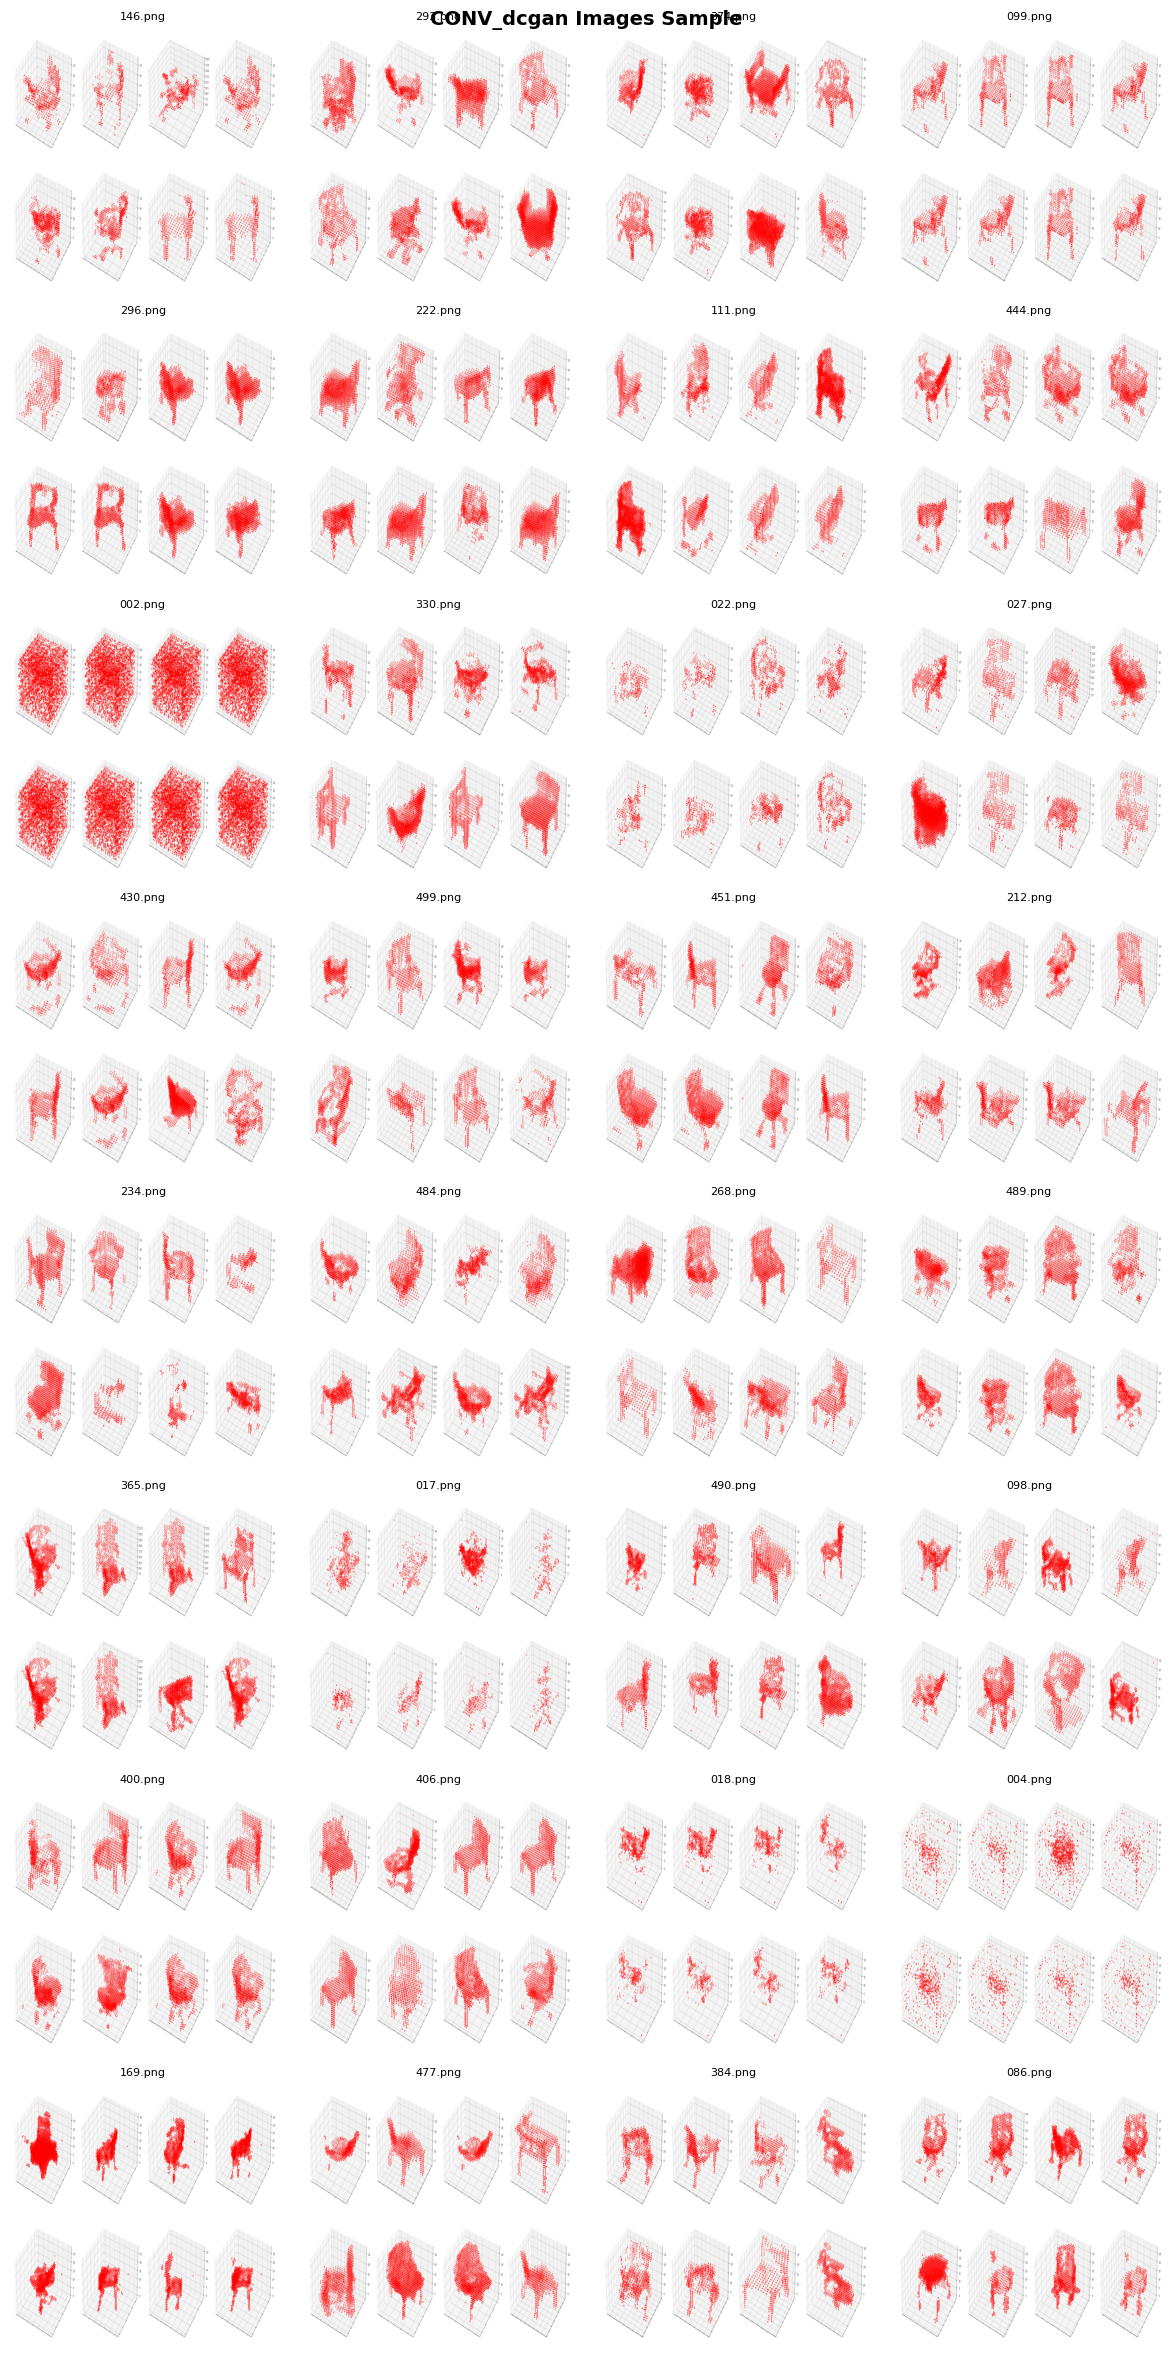

Found 500 images in /content/dcgan_fake_images_resized


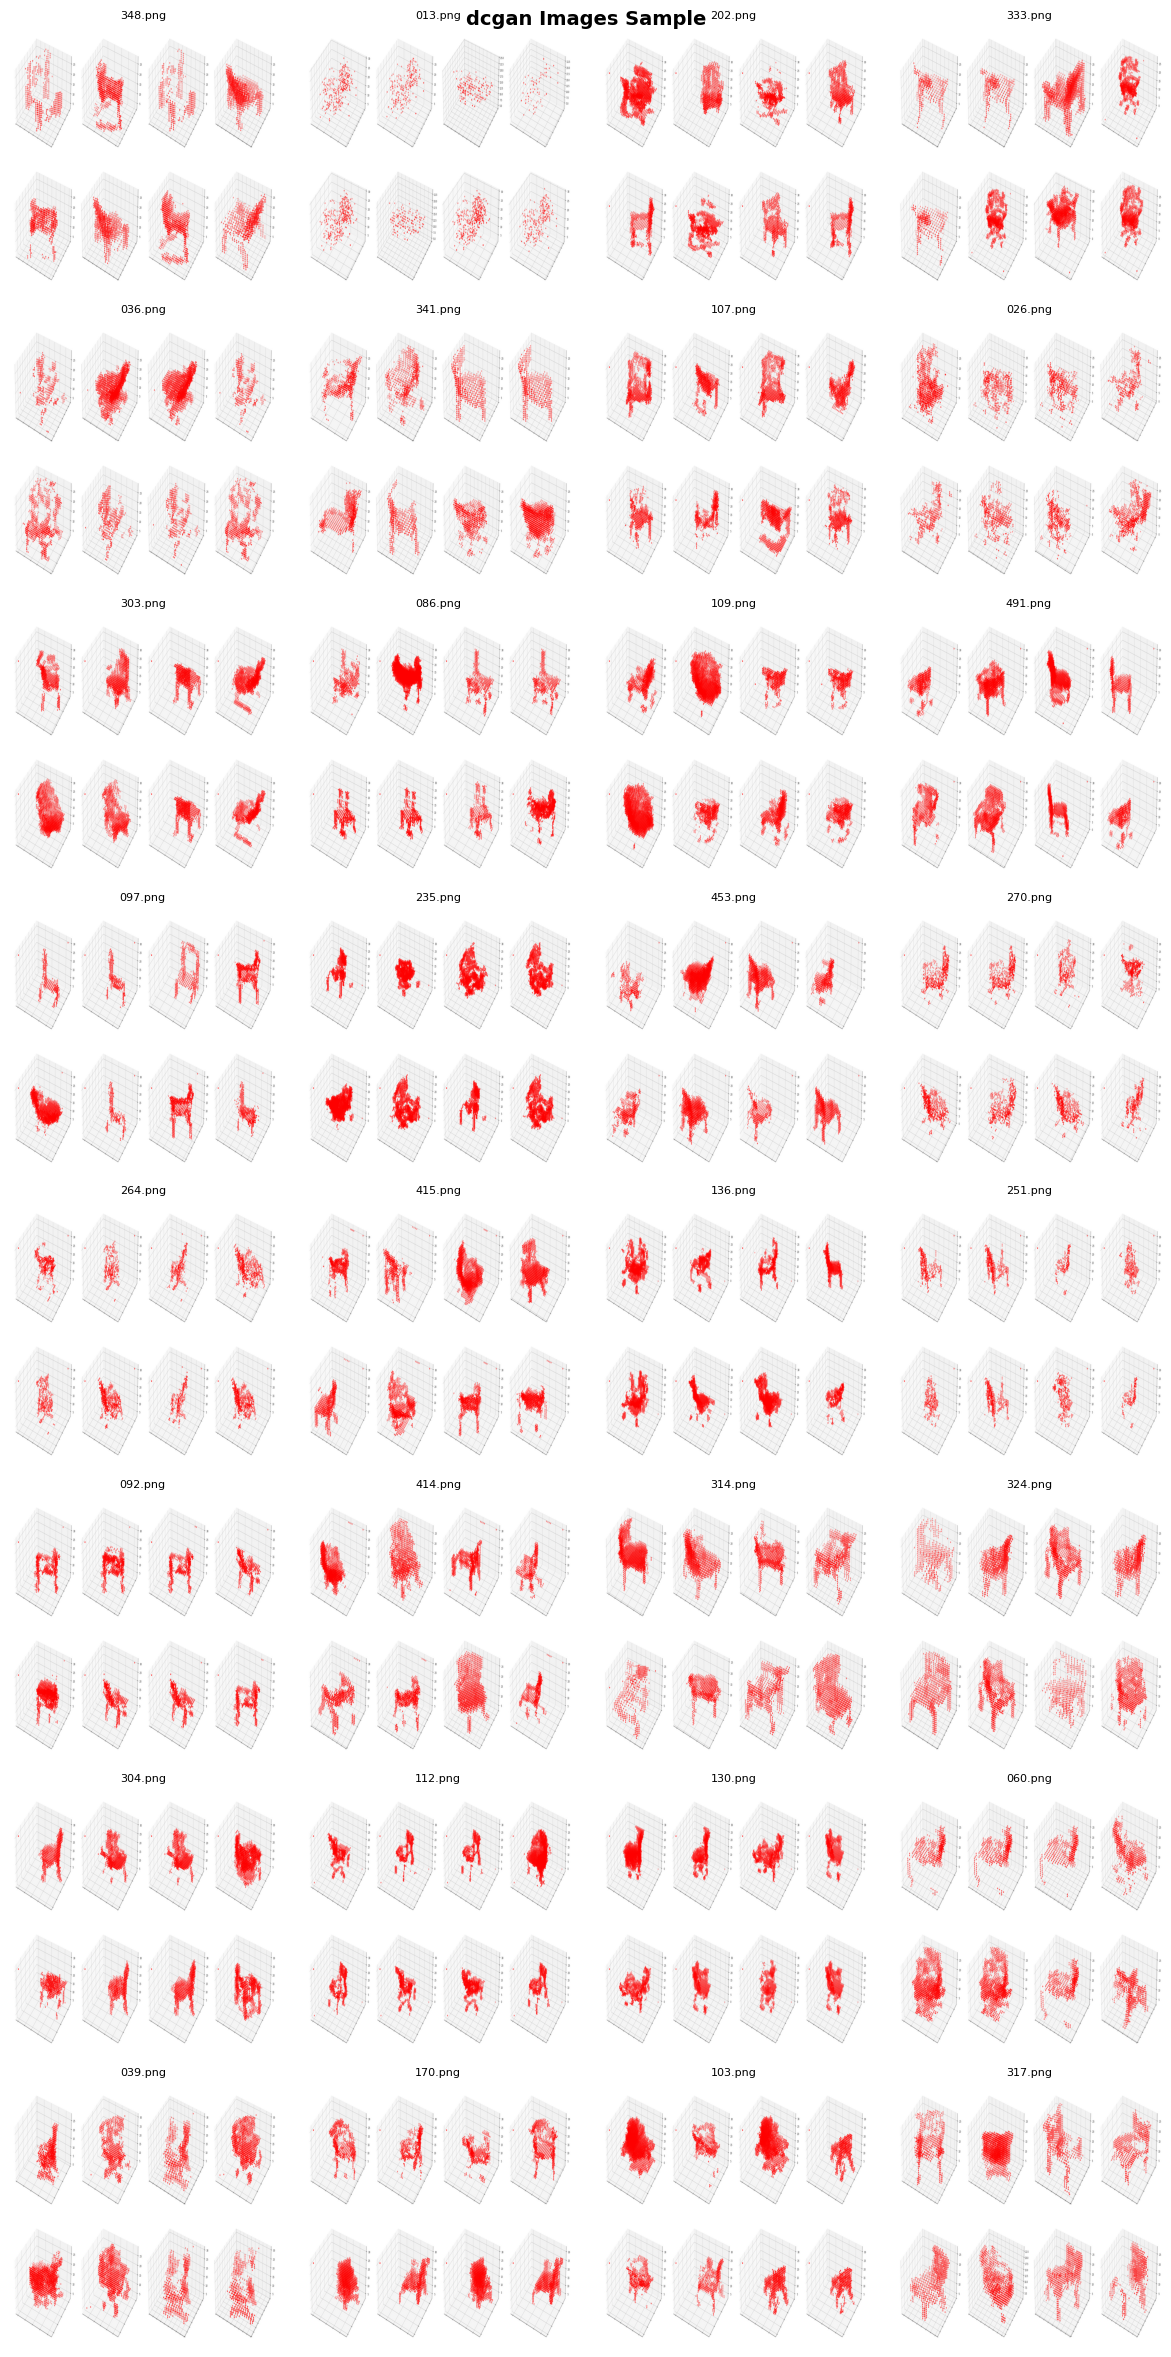

[PosixPath('/content/dcgan_fake_images_resized/348.png'),
 PosixPath('/content/dcgan_fake_images_resized/013.png'),
 PosixPath('/content/dcgan_fake_images_resized/202.png'),
 PosixPath('/content/dcgan_fake_images_resized/333.png'),
 PosixPath('/content/dcgan_fake_images_resized/036.png'),
 PosixPath('/content/dcgan_fake_images_resized/341.png'),
 PosixPath('/content/dcgan_fake_images_resized/107.png'),
 PosixPath('/content/dcgan_fake_images_resized/026.png'),
 PosixPath('/content/dcgan_fake_images_resized/303.png'),
 PosixPath('/content/dcgan_fake_images_resized/086.png'),
 PosixPath('/content/dcgan_fake_images_resized/109.png'),
 PosixPath('/content/dcgan_fake_images_resized/491.png'),
 PosixPath('/content/dcgan_fake_images_resized/097.png'),
 PosixPath('/content/dcgan_fake_images_resized/235.png'),
 PosixPath('/content/dcgan_fake_images_resized/453.png'),
 PosixPath('/content/dcgan_fake_images_resized/270.png'),
 PosixPath('/content/dcgan_fake_images_resized/264.png'),
 PosixPath('/c

In [111]:
# Display 16 random images
display_sample_images(
    folder_path="/content/CONV_dcgan_fake_images_resized",
    n=32,
    title="CONV_dcgan Images Sample"
)

display_sample_images(
    folder_path="/content/dcgan_fake_images_resized",
    n=32,
    title="dcgan Images Sample"
)